# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [91]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [47]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [48]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 13 columns):
Id                 11703 non-null int64
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.2+ MB


In [50]:
df.duplicated().sum()

0

As the columns `Publisher` and `Developer` contain way too many values and also doesn't seem to add any reasonable value to our prediction, let's drop them. Together with the `Id` that's not needed either.

The column `Critic_Count` mirrors the number of critics used in coming up with the `Critic_Score`, meaning double data. The same is true for `User_Count` that adds to `User_Score`. Let's drop both simply counting columns.

In [51]:
#df = df.drop(['Id', 'Publisher', 'Developer', 'Critic_Count', 'User_Count'], axis=1)
df = df.drop(['Id', 'Publisher', 'Developer'], axis=1)

### 2. Preprocessing the Data

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Rating             6978 non-null object
dtypes: float64(6), object(4)
memory usage: 914.4+ KB


The problem is we have tons of missing values! What to do? Let's walk through each of these features:

**2.1. Handling `Rating` column**

In [53]:
df.Rating.unique()

array(['E', nan, 'T', 'M', 'E10+', 'EC', 'RP', 'K-A'], dtype=object)

In [54]:
df.Rating.value_counts()

E       2791
T       2069
M       1109
E10+    1000
EC         5
K-A        2
RP         2
Name: Rating, dtype: int64

According to [Wikipedia](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) ....

In [55]:
def value_replacement(col, to_replace, new_value):
    col.replace(to_replace, new_value, inplace=True)

In [56]:
value_replacement(df.Rating, to_replace='EC', new_value='E')
value_replacement(df.Rating, to_replace='K-A', new_value='E')
value_replacement(df.Rating, to_replace='RP', new_value='None')
value_replacement(df.Rating, to_replace=np.nan, new_value='None')

df.Rating.value_counts()

None    4727
E       2798
T       2069
M       1109
E10+    1000
Name: Rating, dtype: int64

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Rating             11703 non-null object
dtypes: float64(6), object(4)
memory usage: 914.4+ KB


**2.2. Handling `Year_of_release` column**

In [58]:
df1 = df[df['Year_of_Release'].isna()]
df1.tail(10)

,NA_Sales,Platform,Year_of_Release,Genre,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
11020,0.59,PS2,NaN,Sports,0.04,84.0,20.0,6.4,76.0,E
11064,0.58,PC,NaN,Shooter,0.00,81.0,29.0,5.2,1651.0,M
11202,0.11,Wii,NaN,Misc,0.77,NaN,NaN,NaN,NaN,None
11213,0.15,X360,NaN,Action,0.00,60.0,9.0,3.6,138.0,T
11298,0.01,DS,NaN,Platform,0.00,NaN,NaN,tbd,NaN,E10+
11380,0.00,PS3,NaN,Racing,0.01,68.0,24.0,4.5,4.0,None
11390,0.26,GBA,NaN,Action,0.00,NaN,NaN,NaN,NaN,None
11421,0.13,X360,NaN,Puzzle,0.00,78.0,13.0,8.4,11.0,E
11474,0.22,XB,NaN,Shooter,0.00,85.0,54.0,8.2,21.0,M
11615,0.00,Wii,NaN,Shooter,0.02,NaN,NaN,NaN,NaN,None


In [59]:
df.Year_of_Release.max()

2017.0

In [60]:
df.Year_of_Release.describe()

count    11520.00000
mean      2006.55217
std          5.85593
min       1980.00000
25%       2003.00000
50%       2007.00000
75%       2010.00000
max       2017.00000
Name: Year_of_Release, dtype: float64

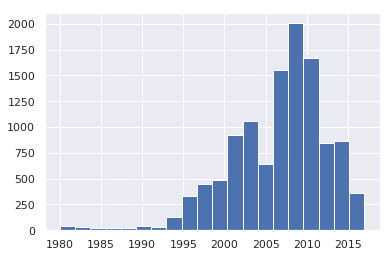

In [61]:
df.Year_of_Release.hist(bins=20);

It might be reasonable to bin the years into periods of roughly 5 years and when doing this, also bin the NaN values into *unknown*.

In [62]:
# bin the year_of_release into periods_of_release
bins = [1980, 1995, 2000, 2005, 2010, 2015, 2017]
labels = ['Before 1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015', '2015-2017']
df['Periods_of_Release'] = pd.cut(df['Year_of_Release'], bins=bins, labels=labels)

# create another category for the unknown release date
df['Periods_of_Release'].replace(to_replace=np.nan, value='Unknown', inplace=True)

In [63]:
df.Periods_of_Release.unique()

array(['2005-2010', 'Before 1995', '2000-2005', '2010-2015', '1995-2000',
       '2015-2017', 'Unknown'], dtype=object)

In [64]:
df.Periods_of_Release.value_counts()

2005-2010      4471
2000-2005      2627
2010-2015      2463
1995-2000      1121
Before 1995     472
2015-2017       360
Unknown         189
Name: Periods_of_Release, dtype: int64

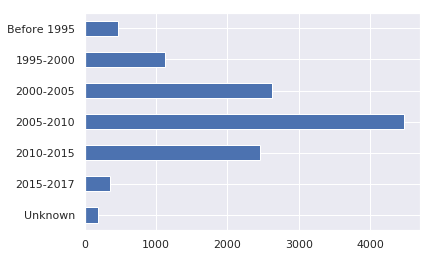

In [65]:
# visualize the distribution of categories
order = ['Unknown', '2015-2017', '2010-2015', '2005-2010',  '2000-2005','1995-2000', 'Before 1995']
df.Periods_of_Release.value_counts().loc[order].plot(kind='barh');

In [66]:
# drop the original year related column
df = df.drop(['Year_of_Release'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              11703 non-null float64
Platform              11703 non-null object
Genre                 11701 non-null object
JP_Sales              11703 non-null float64
Critic_Score          5697 non-null float64
Critic_Count          5697 non-null float64
User_Score            7011 non-null object
User_Count            5332 non-null float64
Rating                11703 non-null object
Periods_of_Release    11703 non-null object
dtypes: float64(5), object(5)
memory usage: 914.4+ KB


**2.3. Handling `User_Score` column**

In [67]:
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '2', '1.6', '1.2', '0.9', '0.7', '0.6', '2.3', '1.3', '0.2'],
      dtype=object)

In [68]:
len(df[df['User_Score'] == 'tbd'])

1679

In [69]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.User_Score.describe()

count    5332.000000
mean        7.125075
std         1.491034
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

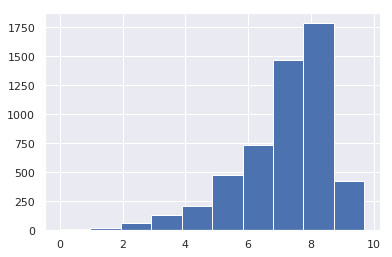

In [70]:
df.User_Score.hist();

In [71]:
df = df.dropna(subset=['User_Score'], axis=0)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              5332 non-null float64
Platform              5332 non-null object
Genre                 5332 non-null object
JP_Sales              5332 non-null float64
Critic_Score          4938 non-null float64
Critic_Count          4938 non-null float64
User_Score            5332 non-null float64
User_Count            5332 non-null float64
Rating                5332 non-null object
Periods_of_Release    5332 non-null object
dtypes: float64(6), object(4)
memory usage: 458.2+ KB


**2.4. Handling `Critic_Score` column**

In [73]:
df.Critic_Score.describe()

count    4938.000000
mean       70.201499
std        13.956140
min        13.000000
25%        62.000000
50%        72.000000
75%        80.000000
max        98.000000
Name: Critic_Score, dtype: float64

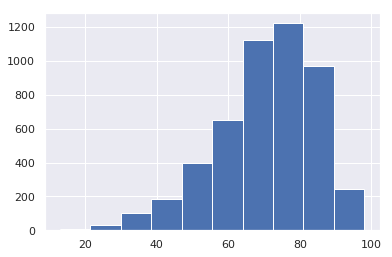

In [74]:
df.Critic_Score.hist();

In [75]:
df = df.dropna(subset=['Critic_Score'], axis=0)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null object
Genre                 4938 non-null object
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
Critic_Count          4938 non-null float64
User_Score            4938 non-null float64
User_Count            4938 non-null float64
Rating                4938 non-null object
Periods_of_Release    4938 non-null object
dtypes: float64(6), object(4)
memory usage: 424.4+ KB


**2.5. Handling `Genre` column**

In [77]:
#df = df.dropna(subset=['Genre'], axis=0)
#df.info()

**2.6. Handling `Platform` column**

In [78]:
df.Platform.value_counts()

PS2     807
X360    621
PS3     584
PC      493
XB      398
Wii     334
DS      325
PSP     282
GC      252
PS4     181
GBA     164
XOne    119
3DS     112
PS      107
PSV      86
WiiU     62
DC       11
Name: Platform, dtype: int64

In [79]:
#df.drop(df[(df.Platform.value_counts() < 100)].index, axis=0, inplace=True)
#df = df.groupby('Platform').filter(lambda x: len(x) > 100)
#df.info()

In [80]:
#df.Platform.value_counts()

## 3. Machine Learning

*Preparing Target & Features*

In [81]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null object
Genre                 4938 non-null object
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
Critic_Count          4938 non-null float64
User_Score            4938 non-null float64
User_Count            4938 non-null float64
Rating                4938 non-null object
Periods_of_Release    4938 non-null object
dtypes: float64(6), object(4)
memory usage: 424.4+ KB


In [83]:
# convert string values in object columns into categorical values
df['Platform'] = df['Platform'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['Periods_of_Release'] = df['Periods_of_Release'].astype('category')
#df['Platform_Groups'] = df['Platform_Groups'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938 entries, 0 to 11702
Data columns (total 10 columns):
NA_Sales              4938 non-null float64
Platform              4938 non-null category
Genre                 4938 non-null category
JP_Sales              4938 non-null float64
Critic_Score          4938 non-null float64
Critic_Count          4938 non-null float64
User_Score            4938 non-null float64
User_Count            4938 non-null float64
Rating                4938 non-null category
Periods_of_Release    4938 non-null category
dtypes: category(4), float64(6)
memory usage: 291.1 KB


In [84]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [85]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [86]:
# scale data
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test  = sc.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


*XGBoost*

In [87]:
# create a baseline
booster = xgb.XGBRegressor()

In [262]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


In [88]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, 
                           max_depth=7, n_estimators=100, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [89]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.5305
r2: 0.5021


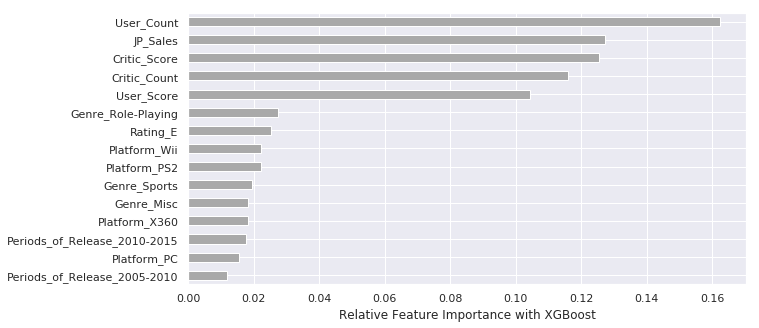

In [90]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');